# Dataset class

In [1]:
import numpy as np
from pgmpy.sampling.Sampling import BayesianModelSampling
from pgmpy.factors.discrete import TabularCPD
import pandas as pd
import random

np.random.seed(42)

class Dataset:
    def __init__(self, size, bn):
        '''
        args:
        - size: number of instances in the dataset
        - bn: the Bayesian network based on which the dataset is generated
        '''
        assert size > 0
        self.size = size
        self.bn = bn
        self.data = self.bn.simulate(n_samples=self.size, show_progress=False, missing_prob=None)

    def view_bn(self):
        model_daft = self.bn.to_daft()
        model_daft.render()
    
    def marginals(self, variables):
        '''
        Return the marginals over the variables
        '''
        # Check for valid variables 
        for variable in variables:
            assert variable in self.data.columns, "one of the variables not in the dataset"

        probs = self.data[variables].value_counts(normalize=True).reset_index(name='prob')

        # Match the above probabilities to a numpy array
        marginals = np.zeros([2]*len(variables))
        for i, row in probs.iterrows():
            index = tuple(row.iloc[:-1].astype(int))
            marginals[index] = row['prob']
        
        return marginals

class MCARDataset(Dataset):
    def __init__(self, size, bn, fraction_observed, observed_rate):
        '''
        args:
        - fraction_observed: a number (0,1] indicating the fraction of variables that are fully-observed
        - observed_rate: a number (0, 1) containing the percentage of observedness for each partially-observed variable
        '''
        super().__init__(size, bn)
        assert fraction_observed > 0 and fraction_observed <= 1, "fraction_observedm must be > 0 and  <= 1"
        self.fraction_observed = fraction_observed

        assert observed_rate > 0 and observed_rate < 1, "observed_rate must be > 0 and  < 1"
        self.observed_rate = observed_rate

        self.generate_m_graph()
        self.generate_partial_data()
        
    def generate_m_graph(self):
        '''
        Generate an m-graph
        Set self.m_graph, self.missing_variables
        '''
        # Initialize the m_graph to a copy of self.bn
        m_graph = self.bn.copy()

        # Get the number of missing variables
        bn_nodes = list(self.bn.nodes)
        num_missing_variable = max(1, int(self.fraction_observed * len(bn_nodes)))

        # Randomly choose the missing variables
        missing_variables = random.sample(bn_nodes, num_missing_variable)

        for _, variable in enumerate(missing_variables):
            # Add proxy variables and R-variables to the m_graph
            proxy_variable = "proxy" + variable
            R_variable = "R" + variable
            m_graph.add_node(proxy_variable)
            m_graph.add_node(R_variable)
            
            # Add edges (variable -> proxy) and (R -> proxy)
            m_graph.add_edge(variable, proxy_variable)
            m_graph.add_edge(R_variable, proxy_variable)

            # Define the CPDs
            cpd_R = TabularCPD(variable=R_variable, variable_card=2,
                               values=[[1-self.observed_rate], [self.observed_rate]],
                               state_names={R_variable: ['unob', 'ob']})
            cpd_proxy = TabularCPD(variable=proxy_variable, variable_card=2, 
                                    values=[[1, 1, 0, 0], 
                                            [0, 0, 1, 1]],
                                    evidence=[R_variable, variable],
                                    evidence_card=[2, self.bn.get_cardinality(variable)],
                                    state_names={proxy_variable: ['mi', 'Y'],
                                                 R_variable: ['unob', 'ob'],
                                                 variable: [0, 1]})
            m_graph.add_cpds(cpd_R, cpd_proxy)

        self.missing_variables = missing_variables
        self.m_graph = m_graph
    
    def generate_partial_data(self):
        '''
        Generate partial data from self.m_graph
        After the partial_data is generated, edit the partial_data so that its
        columns corresponding to self.bn's variables matches that of self.data
        '''
        partial_data = self.m_graph.simulate(n_samples=self.size, show_progress=False, missing_prob=None)
        # The simulate() function returns a df with dtype catgory. Reset the datatype
        for col in partial_data.columns:
            if col.startswith('R') or col.startswith('proxy'):
                partial_data[col] = partial_data[col].astype(str)
            else:
                partial_data[col] = partial_data[col].astype(int)

        
        # Edit the partial_data so that its columns corresponding to self.bn's variables matches that of self.data
        bn_nodes = list(self.bn.nodes)
        partial_data[bn_nodes] = self.data[bn_nodes]

        # Map the 'Y' values in the proxy variable columns to the value of the variable
        proxy_variables = [col for col in partial_data.columns if col.startswith('proxy')]
        for proxy_variable in proxy_variables:
            # Get the variable name
            variable = proxy_variable.replace('proxy', '')

            # Map the data
            partial_data.loc[partial_data[proxy_variable] == 'Y', proxy_variable] = partial_data.loc[partial_data[proxy_variable] == 'Y', variable]

        self.partial_data = partial_data

    def view_m_graph(self):
        model_daft = self.m_graph.to_daft()
        model_daft.render()

class MARDataset(Dataset):
    '''
    MAR where the missing mechanism's parents are the missing variable's fully observed parents and children
    '''
    def __init__(self, size, bn, fraction_observed, num_parents, alpha, beta):
        '''
        args:
        - fraction_observed: a number (0,1] indicating the fraction of variables that are fully-observed
        - num_parents: maximum number of parents for each R-variable
        - alpha, beta: the arguments for a Beta distribution, which will be used to sample the R-variables' CPTs
        '''
        super().__init__(size, bn)
        assert fraction_observed > 0 and fraction_observed <= 1, "fraction_observedm must be > 0 and  <= 1"
        self.fraction_observed = fraction_observed

        assert num_parents > 0, "num_parents must be positive"
        self.num_parents = num_parents

        self.alpha = alpha
        self.beta = beta

        self.generate_m_graph()
        self.generate_partial_data()
    
    def generate_m_graph(self):
        '''
        Generate an m-graph
        Set self.m_graph, self.missing_variables
        '''
        # Initialize the m_graph to a copy of self.bn
        m_graph = self.bn.copy()

        # Get the number of missing variables
        bn_nodes = list(self.bn.nodes)
        num_missing_variable = max(1, int(self.fraction_observed * len(bn_nodes)))

        # Randomly choose the missing variables
        missing_variables = random.sample(bn_nodes, num_missing_variable)

        for index, variable in enumerate(missing_variables):
            # Add proxy variables and R-variables to the m_graph
            proxy_variable = "proxy" + variable
            R_variable = "R" + variable
            m_graph.add_node(proxy_variable)
            m_graph.add_node(R_variable)

            # Find the R-variable's parents, which are taken from the fully-observed
            # variables, prioritising the missing variable's parents and children
            priority_parents = list(self.bn.predecessors(variable)) + list(self.bn.successors(variable))
            if self.num_parents <= len(priority_parents):
                R_parents = priority_parents[:self.num_parents]
            else:
                R_parents = priority_parents
                random.shuffle(bn_nodes)
                for node in bn_nodes:
                    if len(R_parents) == self.num_parents:
                        break
                    if (node != variable and node not in missing_variables and node not in R_parents):
                        R_parents.append(node)
            
            # Add edges (variable -> proxy), (R -> proxy), and (R_parent -> R)
            m_graph.add_edge(variable, proxy_variable)
            m_graph.add_edge(R_variable, proxy_variable)
            for R_parent in R_parents:
                m_graph.add_edge(R_parent, R_variable)            

            # Define the CPDs
            # Define the state_names for R's CPD
            cpd_R_state_names = {R_variable: ['unob', 'ob']}
            for R_parent in R_parents:
                cpd_R_state_names[R_parent] = [0, 1]

            # Define the values for R's CPD
            values_R_0 = []
            for _ in range(2**len(R_parents)):
                values_R_0.append(np.random.beta(self.alpha, self.beta))
            values_R_1 = [(1. - value) for value in values_R_0]
            cpd_R_values = [values_R_0, values_R_1]

            cpd_R = TabularCPD(variable=R_variable, variable_card=2,
                               values=cpd_R_values,
                               evidence=R_parents,
                               evidence_card=[2] * len(R_parents),
                               state_names=cpd_R_state_names)
            
            cpd_proxy = TabularCPD(variable=proxy_variable, variable_card=2, 
                                    values=[[1, 1, 0, 0], 
                                            [0, 0, 1, 1]],
                                    evidence=[R_variable, variable],
                                    evidence_card=[2, self.bn.get_cardinality(variable)],
                                    state_names={proxy_variable: ['mi', 'Y'],
                                                 R_variable: ['unob', 'ob'],
                                                 variable: [0, 1]})
            
            m_graph.add_cpds(cpd_R, cpd_proxy)

        self.missing_variables = missing_variables
        self.m_graph = m_graph
    
    def generate_partial_data(self):
        '''
        Generate partial data from self.m_graph
        After the partial_data is generated, edit the partial_data so that its
        columns corresponding to self.bn's variables matches that of self.data
        Set self.partial_data
        '''
        partial_data = self.m_graph.simulate(n_samples=self.size, show_progress=False, missing_prob=None)
        # The simulate() function returns a df with dtype catgory. Reset the datatype
        for col in partial_data.columns:
            if col.startswith('R') or col.startswith('proxy'):
                partial_data[col] = partial_data[col].astype(str)
            else:
                partial_data[col] = partial_data[col].astype(int)
        
        # Edit the partial_data so that its columns corresponding to self.bn's variables matches that of self.data
        bn_nodes = list(self.bn.nodes)
        partial_data[bn_nodes] = self.data[bn_nodes]

        # Map the 'Y' values in the proxy variable columns to the value of the variable
        proxy_variables = [col for col in partial_data.columns if col.startswith('proxy')]
        for proxy_variable in proxy_variables:
            # Get the variable name
            variable = proxy_variable.replace('proxy', '')
            
            # Map the data
            partial_data.loc[partial_data[proxy_variable] == 'Y', proxy_variable] = partial_data.loc[partial_data[proxy_variable] == 'Y', variable]

        self.partial_data = partial_data

    def view_m_graph(self):
        model_daft = self.m_graph.to_daft()
        model_daft.render()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Algo class

In [2]:
import daft
import networkx as nx
from utils import tensor_mult, get_elements_last_axis

class Learner:
    def __init__(self, dataset):
        self.dataset = dataset
        self.topological_order = list(nx.topological_sort(self.dataset.bn))

    # Helper function   
    def is_topological(self, variables):
        '''
        args:
        - variables: A list of variables whose marginal distribution is calculated.
                     variables list must be respect the topological order

        returns:
        bool: indicating whether variables is in topological order
        '''   
        # Check if variables are in topological order
        is_topological = False
        index_variables = [self.topological_order.index(variable) for variable in variables]
        if sorted(index_variables) == index_variables:
            is_topological = True
        return is_topological
    
    def to_topological_order(self, variables):
        '''
        args:
        - variables: A list of variables in self.bn.nodes

        returns: a list of variables in topological order
        '''
        # Check for valid variables
        for variable in variables:
            assert variable in self.dataset.bn.nodes

        # Reorder variables by the topological order
        return sorted(variables, key=self.topological_order.index)
    
    def reconstruct_model(self, estimate_func):
        '''
        Calculate every θ_x|U (where U is the set of x's parents) that parameterize the Bayesian network
        '''
        bn = self.dataset.bn
        new_bn = bn.copy()
        for x in list(bn.nodes):
            U = self.to_topological_order(list(bn.predecessors(x)))
            Y = self.to_topological_order(U + [x])
            P_Y = estimate_func(Y)
            
            if len(U) == 0:
                cpd = TabularCPD(variable=x, variable_card=2, values=P_Y.reshape((2,1)))
                new_bn.add_cpds(cpd)
            else:
                # Calculate the conditional prob of x given U
                P_U_reciprocal = 1. / np.clip(estimate_func(U), 1e-17, 2)
                a_dims = list(range(P_Y.ndim - 1))
                b_dims = list(range(P_U_reciprocal.ndim))
                P_x_given_U = tensor_mult(P_Y, P_U_reciprocal, a_dims, b_dims)
                # Calculate the CPD of x given U
                cpd_values = get_elements_last_axis(P_x_given_U)
                cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
                cpd_values = np.where(np.isnan(cpd_values), 0.5, cpd_values)
                cpd = TabularCPD(variable=x, variable_card=2, values=cpd_values,
                                 evidence=U, evidence_card=[2]*len(U))
                # Add the cpd to new_bn
                new_bn.add_cpds(cpd)
        return new_bn

class MCARLearner(Learner):
    def __init__(self, dataset):
        super().__init__(dataset)
        # To be used by FMCAR only
        self.cache = {}

    def dmcar(self, variables):
        '''
        args:
        - variables: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(variables)
        '''
        assert self.is_topological(variables)
        dataset = self.dataset
        data = dataset.partial_data

        # Get the lists of missing and fully-observed variables
        Y_m = [variable for variable in variables if variable in dataset.missing_variables]
        Y_o = [variable for variable in variables if variable not in dataset.missing_variables]
        R_Y_m = ["R" + variable for variable in Y_m]
        proxy_Y_m = ["proxy" + variable for variable in Y_m]
        
        # # Check if all the variable lists are in topological order - easy for debugging
        # for variable_list in [Y_o, Y_m]:
        #     assert self.is_topological(variable_list), "{} is not in topological order".format(variable_list)
        
        # Conditioning the data on R_Y_m = 'ob'. Including only the columns in Y_o and proxy_Y_m
        data = data[(data[R_Y_m] == 'ob').all(axis=1)]
        data = data[proxy_Y_m + Y_o]
        
        # Calculate number of instances
        N = len(data)

        # Calculate the probabilities of each unique combination of Y_m values
        probabilities = (data.value_counts() / N).reset_index(name='prob')
        
        # Match the above probabilities to a numpy array
        marginals = np.zeros([2]*len(variables))
        for _, row in probabilities.iterrows():
            index = tuple([int(row.iloc[i]) for i in range(len(variables))])
            marginals[index] = row['prob']
        
        return marginals

    def fmcar(self, Y):
        '''
        args:
        - variables: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(variables)
        '''
        assert self.is_topological(Y)
        
        cache_key = ''.join(Y)
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        elif len(Y) == 0:
            return 1

        # Initialize set of estimates
        estimates = []

        for y in Y:
            # list of y's parent
            U = Y.copy()
            U.remove(y)
            
            # Get the lists of missing and fully-observed Y
            Y_m = [variable for variable in Y if variable in self.dataset.missing_variables]
            R_Y_m = ["R" + variable for variable in Y_m]

            # # Check if all the variable lists are in topological order - easy for debugging
            # assert self.is_topological(Y_m), "Y_m is not in topological order"

            # Conditioning the data on R_Y_m = 'ob'. Including only the columns in Y
            deleted_data = self.dataset.partial_data[(self.dataset.partial_data[R_Y_m] == 'ob').all(axis=1)][Y]
          
            if deleted_data.empty:
                self.cache[cache_key] = np.full(shape=[2]*len(Y), fill_value=1./2**len(Y))
                return self.cache[cache_key]
            
            # Calculate P(y, U), P(U)
            prob = (deleted_data.value_counts(normalize=True)).reset_index(name='prob')
            
            if len(U) >= 1:
                prob_U = (deleted_data[U].value_counts(normalize=True)).reset_index(name='prob_U')
                
                # Merging the above 2 DataFrames on the U columns
                prob_merged = prob.merge(prob_U, on=U, how='left')

                # Match the above probabilities to a numpy array
                P_y_given_U = np.zeros([2]*len(Y))
                for _, row in prob_merged.iterrows():
                    index = tuple(row.iloc[:-2].astype(int))
                    P_y_given_U[index] = row['prob'] / row['prob_U']
            else:
                P_y_given_U = np.array(prob['prob'])

            fmcar_u = self.fmcar(U)

            if not isinstance(fmcar_u, int):
                a_dims = list(range(P_y_given_U.ndim))
                a_dims.remove(Y.index(y))
                b_dims = list(range(fmcar_u.ndim))
                estimates.append(tensor_mult(P_y_given_U, fmcar_u, a_dims, b_dims))
            else:
                estimates.append(P_y_given_U)
        
        self.cache[cache_key] = np.mean(estimates, axis=0)
        
        return self.cache[cache_key]

class MARLearner(Learner):
    def __init__(self, dataset):
        super().__init__(dataset)
        self.cache = {}     # cache for the fmcar_fmar helper function

    def dmar(self, Y):
        '''
        args:
        - variables: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(variables)
        '''
        assert self.is_topological(Y)
        
        dataset = self.dataset
        data = dataset.partial_data

        # Get the lists of missing and fully-observed Y
        Y_m = [variable for variable in Y if variable in dataset.missing_variables]
        Y_o = [variable for variable in Y if variable not in dataset.missing_variables]
        X_o = [variable for variable in list(nx.topological_sort(self.dataset.bn)) if variable not in dataset.missing_variables]
        X_o_prime = self.to_topological_order(list(set(X_o) - set(Y_o)))

        # # Check if all the variable lists are in topological order - easy for debugging
        # for variable_list in [Y_o, Y_m, X_o_prime, X_o]:
        #     assert self.is_topological(variable_list), "{} is not in topological order".format(variable_list)
        
        R_Y_m = ["R" + variable for variable in Y_m]
        proxy_Y_m = ["proxy" + variable for variable in Y_m]

        # Set A for short
        A = X_o_prime + Y_o
        
        # Calculate P(A) on original dataset
        P_A_original = (data[A].value_counts(normalize=True)).reset_index(name='prob_A_original')

        # Conditioning the data on R_Y_m = 'ob'. Including only the columns in A and proxy_Y_m
        observed_data = data[(data[R_Y_m] == 'ob').all(axis=1)][A + proxy_Y_m]

        # Calculate P(proxy_Y_m, A), P(A) on the conditioned_data
        P_A_proxy_Y_m = (observed_data.value_counts(normalize=True)).reset_index(name='prob_A_proxy_Y_m')
        P_A_observed = (observed_data[A].value_counts(normalize=True)).reset_index(name='prob_A_observed')

        # Initialize P(Y_m, A)
        P_A_Y_m = np.zeros(([2] * len(A + Y_m)))

        for _, row in P_A_proxy_Y_m.iterrows():
            index_A_Y_m = tuple(row.iloc[:-1].astype(int))
            probability_A_original = P_A_original[(P_A_original[A] == row.iloc[:len(A)]).all(axis=1)]['prob_A_original'].iloc[0]
            probability_A_observed = P_A_observed[(P_A_observed[A] == row.iloc[:len(A)]).all(axis=1)]['prob_A_observed'].iloc[0]
            P_A_Y_m[index_A_Y_m] = row['prob_A_proxy_Y_m'] / probability_A_observed * probability_A_original
        
        # Sum out along the X_o_prime axis
        X_o_prime_axis = tuple(range(len(X_o_prime)))
        P_Y = np.sum(P_A_Y_m, axis=X_o_prime_axis)

        # Transpose the axis back to Y's order
        Y_1 = Y_o + Y_m
        axes = [Y_1.index(variable) for variable in Y]
        P_Y_transposed = np.transpose(P_Y, axes=axes)

        # Marginalize P_Y_transposed
        P_Y_transposed = P_Y_transposed / P_Y_transposed.sum()

        return P_Y_transposed
    
    def fmar(self, Y):
        '''
        args:
        - variables: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(variables)
        '''
        assert self.is_topological(Y)
        
        dataset = self.dataset
        data = dataset.partial_data

        # Get the lists of missing and fully-observed Y
        Y_m = [variable for variable in Y if variable in dataset.missing_variables]
        Y_o = [variable for variable in Y if variable not in dataset.missing_variables]
        X_o = [variable for variable in list(nx.topological_sort(self.dataset.bn)) if variable not in dataset.missing_variables]
        X_o_prime = self.to_topological_order(list(set(X_o) - set(Y_o)))

        # # Check if all the variable lists are in topological order - easy for debugging
        # for variable_list in [Y_o, Y_m, X_o_prime, X_o]:
        #     assert self.is_topological(variable_list), "{} is not in topological order".format(variable_list)
        
        # Initialize estimated P(X_o_prime, Y_o, Y_m)
        P_X_o_prime_Y_o_Y_m = np.zeros([2] * len(X_o_prime + Y_o + Y_m))

        # Calculate P(X_o)
        prob_X_o = (data[X_o].value_counts(normalize=True)).reset_index(name='prob_X_o')
        
        for _, row in prob_X_o.iterrows():
            partial_data = data[(data[X_o] == row.iloc[:-1]).all(axis=1)]
            index = tuple(row.iloc[:-1].astype(int))
            P_X_o_prime_Y_o_Y_m[index] = row['prob_X_o'] * self.fmcar_fmar(Y_m, partial_data)
        
        # Sum out along the X_o_prime axis
        X_o_prime_axis = tuple([X_o.index(variable) for variable in X_o_prime])
        P_Y = np.sum(P_X_o_prime_Y_o_Y_m, axis=X_o_prime_axis)

        # Transpose the axis back to Y's order
        Y_1 = Y_o + Y_m
        axes = [Y_1.index(variable) for variable in Y]
        P_Y_transposed = np.transpose(P_Y, axes=axes)
        return P_Y_transposed
    
    # Helper function for fmar
    def fmcar_fmar(self, Y, data):
        '''
        args:
        - Y: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(Y)
        '''
        assert self.is_topological(Y)
        
        cache_key = ''.join(Y)
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        if len(Y) == 0:
            return 1

        # Initialize set of estimates
        estimates = []

        for y in Y:
            # list of y's parent
            U = Y.copy()
            U.remove(y)
            
            # Get the lists of missing and fully-observed Y
            Y_m = [variable for variable in Y if variable in self.dataset.missing_variables]
            R_Y_m = ["R" + variable for variable in Y_m]

            # # Check if all the variable lists are in topological order - easy for debugging
            # assert self.is_topological(Y_m), "Y_m is not in topological order"

            # Conditioning the data on R_Y_m = 'ob'. Including only the columns in Y
            deleted_data = data[(data[R_Y_m] == 'ob').all(axis=1)][Y]
            
            if deleted_data.empty:
                self.cache[cache_key] = np.full(shape=[2]*len(Y), fill_value=1./2**len(Y))
                return self.cache[cache_key]

            # Calculate P(y, U), P(U)
            prob = (deleted_data.value_counts(normalize=True)).reset_index(name='prob')
            
            if len(U) >= 1:
                prob_U = (deleted_data[U].value_counts(normalize=True)).reset_index(name='prob_U')
                
                # Merging the above 2 DataFrames on the U columns
                prob_merged = prob.merge(prob_U, on=U, how='left')

                # Match the above probabilities to a numpy array
                P_y_given_U = np.zeros([2]*len(Y))
                for i, row in prob_merged.iterrows():
                    index = tuple(row.iloc[:-2].astype(int))
                    P_y_given_U[index] = row['prob'] / row['prob_U']
            else:
                P_y_given_U = np.array(prob['prob'])

            fmcar_u = self.fmcar_fmar(U, data)

            if not isinstance(fmcar_u, int):
                a_dims = list(range(P_y_given_U.ndim))
                a_dims.remove(Y.index(y))
                b_dims = list(range(fmcar_u.ndim))
                estimates.append(tensor_mult(P_y_given_U, fmcar_u, a_dims, b_dims))
            else:
                estimates.append(P_y_given_U)
        
        self.cache[cache_key] = np.mean(estimates, axis=0)
        
        return self.cache[cache_key]

    # Helper function for ifmar
    def fmcar_ifmar(self, Y, data, cache):
        '''
        args:
        - Y: A list of variables whose marginal distribution is calculated

        Calculate the marginal distribution P(Y)
        '''
        self.is_topological(Y)
        dataset = self.dataset
        
        if len(Y) == 0:
            return 1
        
        cache_key = ''.join(Y)
        if cache_key in cache:
            return cache[cache_key]
        
        # Initialize set of estimates
        estimates = []

        for y in Y:
            # list of y's parent
            U = Y.copy()
            U.remove(y)
            
            # Get the lists of missing and fully-observed Y
            Y_m = [variable for variable in Y if variable in dataset.missing_variables]
            R_Y_m = ["R" + variable for variable in Y_m]

            # Check if all the variable lists are in topological order - easy for debugging
            assert self.is_topological(Y_m), "Y_m is not in topological order"

            # Conditioning the data on R_Y_m = 'ob'. Including only the columns in Y
            deleted_data = data[(data[R_Y_m] == 'ob').all(axis=1)][Y]
            
            if deleted_data.empty:
                cache[cache_key] = np.full(shape=[2]*len(Y), fill_value=1./2**len(Y))
                return cache[cache_key]

            # Calculate P(y, U), P(U)
            prob = (deleted_data.value_counts(normalize=True)).reset_index(name='prob')
            
            if len(U) >= 1:
                prob_U = (deleted_data[U].value_counts(normalize=True)).reset_index(name='prob_U')
                
                # Merging the above 2 DataFrames on the U columns
                prob_merged = prob.merge(prob_U, on=U, how='left')

                # Match the above probabilities to a numpy array
                P_y_given_U = np.zeros([2]*len(Y))
                for i, row in prob_merged.iterrows():
                    index = tuple(row.iloc[:-2].astype(int))
                    P_y_given_U[index] = row['prob'] / row['prob_U']
            else:
                P_y_given_U = np.array(prob['prob'])

            fmcar_u = self.fmcar_ifmar(U, data, cache)

            if not isinstance(fmcar_u, int):
                a_dims = list(range(P_y_given_U.ndim))
                a_dims.remove(Y.index(y))
                b_dims = list(range(fmcar_u.ndim))
                estimates.append(tensor_mult(P_y_given_U, fmcar_u, a_dims, b_dims))
            else:
                estimates.append(P_y_given_U)
        
        cache[cache_key] = np.mean(estimates, axis=0)
        
        return cache[cache_key]

    def idmar(self, Y):
        '''
        args:
        - Y: A list of Y whose marginal distribution is calculated

        Calculate the marginal distribution P(Y)
        '''
        assert self.is_topological(Y)
        dataset = self.dataset
        data = dataset.partial_data

        # Get the lists of missing and fully-observed Y
        Y_m = [variable for variable in Y if variable in dataset.missing_variables]
        Y_o = [variable for variable in Y if variable not in dataset.missing_variables]
        R_Y_m = ["R" + variable for variable in Y_m]
        
        # Get W_0_prime - the list of parents of R_Y_m outside Y
        parent_list = []
        for variable in R_Y_m:
            parent_list.append(list(dataset.m_graph.predecessors(variable)))
        W_o = set().union(*parent_list)
        W_o_prime = self.to_topological_order(list(W_o - set(Y)))
        W_o = self.to_topological_order(W_o)
        
        # # Check if all the variable lists are in topological order - easy for debugging
        # for variable_list in [Y_o, Y_m, W_o, W_o_prime]:
        #     assert self.is_topological(variable_list), "{} is not in topological order".format(variable_list)

        # Get the proxy_Y_m - the proxy of missing Y
        proxy_Y_m = ["proxy" + variable for variable in Y_m]
        
        # Let A be the union of Y_o and W_o_prime
        A = Y_o + W_o_prime

        # Calculate the marginals P_D(A)
        marginals_A = (data[A].value_counts(normalize=True)).reset_index(name='marginals_A')

        # Conditioning the data on R_Y_m = 'ob'. Including only the columns in Y_o, proxy_Y_m, and W_0_prime
        deleted_data = data[(data[R_Y_m] == 'ob').all(axis=1)][A + proxy_Y_m]
        
        # Get the probabilities P(A)
        prob_A = (deleted_data[A].value_counts(normalize=True)).reset_index(name='prob_A')

        # Calculate P(proxy_Y_m, A)
        prob = (deleted_data.value_counts(normalize=True)).reset_index(name='prob')

        # Merging the above 2 DataFrames on the A columns
        prob_merged = prob.merge(prob_A, on=A, how='left').merge(marginals_A, on=A, how='left')

        # Match the above probabilities to a numpy array
        P_Y = np.zeros([2]*len(A+proxy_Y_m))
        for i, row in prob_merged.iterrows():
            index = tuple(row.iloc[:-3].astype(int))
            P_Y[index] = row['prob'] / row['prob_A'] * row['marginals_A']

        # Take the sum by W_o_prime
        P_Y_summed = P_Y.sum(axis=tuple(range(len(Y_o), len(A))))
        
        # Transpose P_Y_summed so that the axes order matches Y's variable order
        Y_1 = Y_o + Y_m
        axes = [Y_1.index(variable) for variable in Y]
        P_Y_transposed = np.transpose(P_Y_summed, axes=axes)

        P_Y_normalized = P_Y_transposed / P_Y_transposed.sum()
        
        return P_Y_normalized

    def ifmar(self, Y):
        '''
        args:
        - Y: A list of Y whose marginal distribution is calculated

        Calculate the marginal distribution P(Y)
        '''
        assert self.is_topological(Y)
        data = self.dataset.partial_data

        # Get the lists of missing and fully-observed Y
        Y_o = [variable for variable in Y if variable not in self.dataset.missing_variables]
        Y_m = [variable for variable in Y if variable in self.dataset.missing_variables]
        R_Y_m = ["R" + variable for variable in Y_m]
        X_o = [variable for variable in list(nx.topological_sort(self.dataset.bn)) if variable not in self.dataset.missing_variables]
        X_o_prime = self.to_topological_order(list(set(X_o) - set(Y_o)))
                
        # Get W_o - the list of R_Y_m's parents
        parent_list = []
        for variable in R_Y_m:
            parent_list.append(list(self.dataset.m_graph.predecessors(variable)))
        W_o = self.to_topological_order(list(set().union(*parent_list) & set(X_o)))

        # # Check if all the variable lists are in topological order - easy for debugging
        # for variable_list in [Y_o, Y_m, X_o, X_o_prime, W_o]:
        #     assert self.is_topological(variable_list), "{} is not in topological order".format(variable_list)

        # Initialize estimated P(X_o_prime, Y_o, Y_m)
        P_X_o_prime_Y_o_Y_m = np.zeros([2] * len(X_o_prime + Y_o + Y_m))

        # Get the W_o columns of W_o
        data_W_o = self.dataset.partial_data[W_o] if len(W_o) >= 1 else self.dataset.partial_data
        
        # Calculate P(W_o)
        prob_W_o = (data_W_o.value_counts(normalize=True)).reset_index(name='prob_W_o')

        # Calculate P(X_o) where (X_o = Y_o + X_o_prime)
        prob_X_o = (self.dataset.partial_data[X_o].value_counts(normalize=True)).reset_index(name='prob_X_o')

        for _, row in prob_W_o.iterrows():
            partial_data = self.dataset.partial_data[(data_W_o == row.iloc[:-1]).all(axis=1)]
            fmcar = self.fmcar_ifmar(Y_m, partial_data, {})

            # Choose the rows of prob_X_o whose W_o values correspond to that of the current iteration
            if len(W_o) >= 1:
                matching_X_o = prob_X_o[(prob_X_o[W_o] == row.iloc[:-1]).all(axis=1)]
            else:
                matching_X_o = prob_X_o

            for __, row_prime in matching_X_o.iterrows():
                index = tuple(row_prime.iloc[:-1].astype(int))
                P_X_o_prime_Y_o_Y_m[index] = row_prime['prob_X_o'] * fmcar
        
        # Sum out along the X_o_prime axis
        X_o_prime_axis = tuple([X_o.index(variable) for variable in X_o_prime])
        P_Y = np.sum(P_X_o_prime_Y_o_Y_m, axis=X_o_prime_axis)

        # Transpose the axis back to Y's order
        Y_1 = Y_o + Y_m
        axes = [Y_1.index(variable) for variable in Y]
        P_Y_transposed = np.transpose(P_Y, axes=axes)
        
        return P_Y_transposed

# Mini-test

## Making Bayes nets

<Axes:>

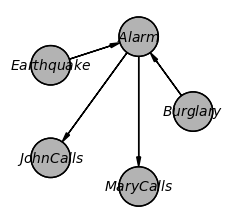

In [3]:
# Adapted from code created by Microsoft Copilot following the prompt:
# "Write code using Python's pgmpy to make the classical alarm network"

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Define the structure of the network
bayes_net = DiscreteBayesianNetwork([('Burglary', 'Alarm'),
                         ('Earthquake', 'Alarm'),
                         ('Alarm', 'JohnCalls'),
                         ('Alarm', 'MaryCalls')])

# Define the CPDs
cpd_burglary = TabularCPD(variable='Burglary', variable_card=2, values=[[0.8], [0.2]])
cpd_earthquake = TabularCPD(variable='Earthquake', variable_card=2, values=[[0.7], [0.3]])
cpd_alarm = TabularCPD(variable='Alarm', variable_card=2, 
                       values=[[0.999, 0.71, 0.06, 0.05], 
                               [0.001, 0.29, 0.94, 0.95]],
                       evidence=['Burglary', 'Earthquake'], evidence_card=[2, 2])
cpd_johncalls = TabularCPD(variable='JohnCalls', variable_card=2, 
                           values=[[0.95, 0.1], 
                                   [0.05, 0.9]],
                           evidence=['Alarm'], evidence_card=[2])
cpd_marycalls = TabularCPD(variable='MaryCalls', variable_card=2, 
                           values=[[0.99, 0.3], 
                                   [0.01, 0.7]],
                           evidence=['Alarm'], evidence_card=[2])

# Add CPDs to the model
bayes_net.add_cpds(cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls)

# Check if the model is valid
assert bayes_net.check_model(), "invalid Bayes net"

# Visualize the model
model_daft = bayes_net.to_daft()
# To open the plot
model_daft.render()

In [4]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD

def get_node_names(n_nodes):
    return ["X{}".format(i) for i in range(0, n_nodes)]

def generate_bayes_net(n_nodes):
    model = DiscreteBayesianNetwork.get_random(n_nodes=n_nodes,
                                               edge_prob=2.2/n_nodes,   # so that number of edges = O(number of nodes)
                                               node_names=get_node_names(n_nodes),
                                               n_states=2,
                                               seed=42)
    model.get_random_cpds(n_states=2, inplace=True, seed=42)
    return model

## Making the datasets

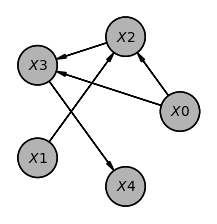

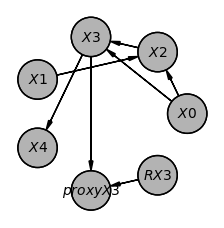

In [5]:
model5 = generate_bayes_net(5)
mcar_dataset = MCARDataset(10000, model5, 0.3, 0.7)
mcar_dataset.view_bn()
mcar_dataset.view_m_graph()

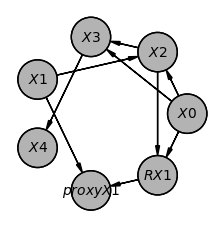

In [6]:
mar_dataset = MARDataset(10000, model5, 0.3, 2, 0.5, 0.5)
mar_dataset.view_m_graph()

## Making the learner objects

### Testing MCAR

In [7]:
models = [bayes_net]
mcar_learner = MCARLearner(mcar_dataset)
variables = list(nx.topological_sort(model5))
mcar_marginals = mcar_dataset.marginals(variables)

for model in models:
    print("DMCAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mcar_learner.dmcar(variables) - mcar_marginals))
    print("FMCAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mcar_learner.fmcar(variables) - mcar_marginals))

DMCAR difference for model 5:
[[[[[-0.00466829 -0.00361819]
    [-0.00892616 -0.0185286 ]]

   [[ 0.02387547  0.02556188]
    [ 0.01298561  0.01123855]]]


  [[[-0.00315901  0.00553085]
    [ 0.01991522  0.02369535]]

   [[-0.01077951 -0.00974502]
    [-0.0244722  -0.05726105]]]]



 [[[[-0.01230425 -0.00836388]
    [-0.01050284 -0.01675861]]

   [[-0.01873347 -0.02259026]
    [ 0.01898866  0.04422336]]]


  [[[ 0.00865599  0.01702354]
    [ 0.01282638  0.01069778]]

   [[-0.00608925  0.0016278 ]
    [-0.00092271  0.00057689]]]]]

FMCAR difference for model 5:
[[[[[ 4.88513887e-03 -9.52441946e-03]
    [ 1.08036250e-03  1.30513388e-03]]

   [[ 4.86488598e-05 -2.03524590e-04]
    [ 6.75000325e-04 -1.56571370e-04]]]


  [[[ 1.09995197e-03 -7.77215178e-04]
    [ 9.35424109e-05  2.57441782e-05]]

   [[-3.34569297e-04 -2.11847640e-04]
    [ 2.89858224e-03 -2.60802552e-03]]]]



 [[[[ 1.39427469e-03 -3.48827607e-04]
    [ 2.72339113e-03 -2.02501188e-03]]

   [[ 2.32874818e-03 -1.66480952e-04]

### Testing MAR

In [8]:
mar_learner = MARLearner(mar_dataset)
variables = list(nx.topological_sort(model5))
mar_marginals = mar_dataset.marginals(variables)

for model in models:
    print("FMAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mar_learner.fmar(variables) - mar_marginals))
    print("DMAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mar_learner.dmar(variables) - mar_marginals))
    print("IDMAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mar_learner.idmar(variables) - mar_marginals))
    print("IFMAR difference for model {}:\n{}\n".format(len(list(model.nodes)), mar_learner.ifmar(variables) - mar_marginals))

FMAR difference for model 5:
[[[[[-4.93177738e-04 -1.43447038e-04]
    [ 5.52962298e-05 -1.54219031e-04]]

   [[ 1.98739677e-02  2.17184919e-02]
    [ 3.41000000e-02  5.68472172e-02]]]


  [[[ 4.93177738e-04  1.43447038e-04]
    [-5.52962298e-05  1.54219031e-04]]

   [[-1.98739677e-02 -2.17184919e-02]
    [-3.41000000e-02 -5.68472172e-02]]]]



 [[[[ 8.80700180e-03  6.98671454e-03]
    [ 5.46804309e-03  1.01436266e-02]]

   [[ 9.55709156e-03  1.04807899e-02]
    [ 8.80412926e-03  1.25732496e-02]]]


  [[[-8.80700180e-03 -6.98671454e-03]
    [-5.46804309e-03 -1.01436266e-02]]

   [[-9.55709156e-03 -1.04807899e-02]
    [-8.80412926e-03 -1.25732496e-02]]]]]

DMAR difference for model 5:
[[[[[-0.00153709 -0.00014345]
    [-0.00037333  0.00029648]]

   [[-0.00103432 -0.00021818]
    [-0.00028671 -0.00064   ]]]


  [[[ 0.00153709  0.00014345]
    [ 0.00037333 -0.00029648]]

   [[ 0.00103432  0.00021818]
    [ 0.00028671  0.00064   ]]]]



 [[[[ 0.0010383  -0.00063802]
    [ 0.00023333  0.001

# Experiment

## Global settings

In [9]:
dataset_size = [10 ** i for i in range(2,7)]
time_limits = [60]   # 5mins, 25mins
model_size = (5, 10, 20, 50, 100)
models = []
for n_nodes in model_size:
    models.append(generate_bayes_net(n_nodes))

In [10]:
# A helper function that executes a function within a time limit

# Written by Microsoft CoPilot with the prompts: "I have this Python
# line of code:  new_fmcar_model = mcar_learner.reconstruct_model(mcar_learner.fmcar)
# Write Python code to set a running time limit of 5 minutes to this line of code" and
# "Refactor the above into a function with the following arguments: time_limit,
# function to be executed, and it's arguments. The function should return the output of
# function to be executed if time limit is not exceeded, otherwise None"

import signal

def execute_with_timeout(time_limit, func, *args, **kwargs):
    # Define a handler for the timeout
    def handler(signum, frame):
        raise TimeoutError("The operation timed out!")

    # Set the signal handler for SIGALRM
    signal.signal(signal.SIGALRM, handler)

    # Set the alarm for the specified time limit
    signal.alarm(time_limit)

    try:
        # Execute the function with the provided arguments
        result = func(*args, **kwargs)
        return result
    except TimeoutError as e:
        print(e)
        return None
    finally:
        # Disable the alarm
        signal.alarm(0)

## Scalability of D/F-M(C)AR vs EM under a time-limit

In [11]:
from pgmpy.metrics import log_likelihood_score
from pgmpy.estimators import ExpectationMaximization

medium_and_big_models = models[:]

# Initializing the LL arrays
ll_em = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_dmcar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_fmcar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_dmar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_fmar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_idmar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)
ll_ifmar = np.full(shape=(len(dataset_size), len(medium_and_big_models), len(time_limits)), fill_value=np.nan)

In [ ]:
# ll_em = array([[[-3.00996457e+02],
#         [-6.42386773e+02],
#         [-1.26662475e+03],
#         [-3.11362861e+03],
#         [-6.15102513e+03]],

#        [[-3.04237238e+03],
#         [-6.46918008e+03],
#         [-1.29320133e+04],
#         [-3.20531252e+04],
#         [-6.28054901e+04]],

#        [[-3.05494851e+04],
#         [-6.43762546e+04],
#         [-1.29431521e+05],
#         [-3.21344507e+05],
#         [            nan]],

#        [[-3.04740718e+05],
#         [-6.44530713e+05],
#         [            nan],
#         [            nan],
#         [            nan]],

#        [[-3.04799804e+06],
#         [-6.44427509e+06],
#         [            nan],
#         [            nan],
#         [            nan]]])

# ll_em = array([[[-2.96663813e+02,             nan],
#         [-6.23740203e+02,             nan],
#         [-1.25814209e+03,             nan],
#         [-3.09297896e+03,             nan],
#         [-6.09657344e+03,             nan]],

#        [[-2.99381332e+03,             nan],
#         [-6.45745287e+03,             nan],
#         [-1.29558251e+04,             nan],
#         [-3.19602239e+04,             nan],
#         [-6.29023894e+04,             nan]],

#        [[-3.05756520e+04,             nan],
#         [-6.44513773e+04,             nan],
#         [-1.29215069e+05,             nan],
#         [-3.20972301e+05,             nan],
#         [-6.31620886e+05,             nan]],

#        [[-3.05099803e+05,             nan],
#         [-6.44297321e+05,             nan],
#         [-1.29170680e+06,             nan],
#         [-3.20988755e+06,             nan],
#         [            nan,             nan]],

#        [[-3.05075982e+06,             nan],
#         [-6.44435928e+06,             nan],
#         [            nan,             nan],
#         [            nan,             nan],
#         [            nan,             nan]]])

for i, size in enumerate(dataset_size):
    for j, model in enumerate(medium_and_big_models):
        for k, time_limit in enumerate(time_limits):
            if i <= 3:
                continue
            # Create the MAR dataset and MAR learner
            mar_dataset = MARDataset(size, model, 0.9, 2, 0.5, 0.5)
            
            print("Doing experiment at dataset size {}, model size {}, and time-limit {}".format(size, len(model.nodes), time_limit))
            
            # Measure the LL of EM
            new_em_model = DiscreteBayesianNetwork()
            new_em_model.add_nodes_from(list(model.nodes))
            new_em_model.add_edges_from(list(model.edges))
            estimator = ExpectationMaximization(new_em_model, mar_dataset.data)
            cpds = execute_with_timeout(time_limit, estimator.get_parameters, n_jobs=2, seed=42)
            if cpds is not None:
                for cpd in cpds:
                    new_em_model.add_cpds(cpd)
                ll_em[i][j][k] = log_likelihood_score(new_em_model, mar_dataset.data)

In [ ]:
ll_dmcar

In [ ]:
# ll_dmcar = array([[[-3.17833423e+02, -3.17455227e+02],
#         [-6.47185409e+02, -6.67581608e+02]],

#        [[-3.10518912e+03, -3.13057982e+03],
#         [-6.44859480e+03, -6.72161911e+03]],

#        [[-3.23696730e+04, -3.22509823e+04],
#         [-6.82426511e+04, -6.53836708e+04]],

#        [[-3.05222828e+05, -3.04746447e+05],
#         [-6.44474358e+05, -6.44054324e+05]],

#        [[-3.09512033e+06, -3.21164153e+06],
#         [-6.44715501e+06, -6.63364330e+06]]])

# ll_dmcar = array([[[-1.26819225e+03, -1.27637628e+03],
#         [-3.12974782e+03, -3.18113942e+03],
#         [-6.30385963e+03, -6.27206400e+03]],

#        [[-1.31716689e+04, -1.35726229e+04],
#         [-3.32127433e+04, -3.28961186e+04],
#         [-6.45927658e+04, -6.55808220e+04]],

#        [[-1.32570773e+05, -1.36457267e+05],
#         [-3.38296905e+05, -3.34271000e+05],
#         [-6.60386135e+05, -6.61128479e+05]],

#        [[-1.32775759e+06, -1.36270763e+06],
#         [-3.33410822e+06, -3.32902109e+06],
#         [-6.52700096e+06, -6.63290272e+06]]
# ,
#        [[-13303348.01866344, -13191660.91969467],
#         [-32937173.64262601, -33181077.80294458],
#         [-65826597.98730116, -66320096.18697526]]])


for i, size in enumerate(dataset_size):
    for j, model in enumerate(medium_and_big_models):
        for k, time_limit in enumerate(time_limits):
            if i>2:
                break
            # Create the MCAR dataset and MCAR learner
            mcar_dataset = MCARDataset(size, model, 0.3, 0.7)
            mcar_learner = MCARLearner(mcar_dataset)
            
            print("Doing experiment at dataset size {}, model size {}, and time-limit {}".format(size, len(model.nodes), time_limit))
            
            # Measure the LL of DMCAR
            new_dmcar_model = execute_with_timeout(time_limit, mcar_learner.reconstruct_model, mcar_learner.dmcar)
            if new_dmcar_model is not None:
                ll_dmcar[i][j][k] = log_likelihood_score(new_dmcar_model, mcar_dataset.data)

In [12]:
# ll_fmcar = array([[[-2.99637471e+02],
#         [-6.41922451e+02],
#         [           -inf],
#         [           -inf],
#         [           -inf]],

#        [[-3.02697526e+03],
#         [-6.46549999e+03],
#         [-1.30582527e+04],
#         [           -inf],
#         [           -inf]],

#        [[-3.05336511e+04],
#         [-6.47904452e+04],
#         [-1.29787431e+05],
#         [           -inf],
#         [           -inf]],

#        [[-3.05803363e+05],
#         [-6.47507741e+05],
#         [-1.29910784e+06],
#         [-3.22056987e+06],
#         [            nan]],

#        [[-3.05741527e+06],
#         [-6.47566817e+06],
#         [-1.29932479e+07],
#         [            nan],
#         [            nan]]])
                   
# ll_fmcar = array([[[-2.91588454e+02, -3.15351053e+02],
#         [-6.57567729e+02, -6.53853334e+02]],

#        [[-3.05734868e+03, -3.06032743e+03],
#         [-6.44788276e+03, -6.45778538e+03]],

#        [[-3.05255654e+04, -3.05869140e+04],
#         [-6.48520231e+04, -6.48097699e+04]],

#        [[-3.05695378e+05, -3.05264197e+05],
#         [-6.47982133e+05, -6.47761252e+05]],

#        [[-3.05596068e+06, -3.05664852e+06],
#         [-6.47566042e+06, -6.47652663e+06]]])

# ll_fmcar = array([[[-1.27318536e+03, -1.27096887e+03],
#         [-3.02355337e+03, -3.11348598e+03],
#         [-6.12712864e+03, -6.07442148e+03]],

#        [[-1.30283451e+04, -1.29349538e+04],
#         [-3.21121828e+04, -3.19539727e+04],
#         [-6.30139649e+04, -6.33881095e+04]],

#        [[-1.30051771e+05, -1.29948877e+05],
#         [-3.22385682e+05, -3.22383128e+05],
#         [-6.33582755e+05, -6.33803898e+05]],

#        [[-1.29937146e+06, -1.29935672e+06],
#         [-3.22053476e+06, -3.22067753e+06],
#         [-6.33894421e+06, -6.33918753e+06]],

#        [[-1.29954156e+07, -1.29948488e+07],
#         [            nan, -3.22031214e+07],
#         [            nan, -6.33838794e+07]]])

for i, size in enumerate(dataset_size):
    for j, model in enumerate(medium_and_big_models):
        for k, time_limit in enumerate(time_limits):
            # Create the MCAR dataset and MCAR learner
            mcar_dataset = MCARDataset(size, model, 0.3, 0.7)
            mcar_learner = MCARLearner(mcar_dataset)
            
            print("Doing experiment at dataset size {}, model size {}, and time-limit {}".format(size, len(model.nodes), time_limit))
            
            # Measure the LL of FMCAR
            new_fmcar_model = execute_with_timeout(time_limit, mcar_learner.reconstruct_model, mcar_learner.fmcar)
            if new_fmcar_model is not None:
                ll_fmcar[i][j][k] = log_likelihood_score(new_fmcar_model, mcar_dataset.data)

Doing experiment at dataset size 100, model size 5, and time-limit 60
Doing experiment at dataset size 100, model size 10, and time-limit 60


Doing experiment at dataset size 100, model size 20, and time-limit 60


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 100, model size 50, and time-limit 60


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 100, model size 100, and time-limit 60


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to di

Doing experiment at dataset size 1000, model size 5, and time-limit 60
Doing experiment at dataset size 1000, model size 10, and time-limit 60


Doing experiment at dataset size 1000, model size 20, and time-limit 60


Doing experiment at dataset size 1000, model size 50, and time-limit 60


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_95022/2992779543.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 1000, model size 100, and time-limit 60


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 10000, model size 5, and time-limit 60


Doing experiment at dataset size 10000, model size 10, and time-limit 60


Doing experiment at dataset size 10000, model size 20, and time-limit 60


Doing experiment at dataset size 10000, model size 50, and time-limit 60


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 10000, model size 100, and time-limit 60


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 100000, model size 5, and time-limit 60


Doing experiment at dataset size 100000, model size 10, and time-limit 60


Doing experiment at dataset size 100000, model size 20, and time-limit 60


Doing experiment at dataset size 100000, model size 50, and time-limit 60


Doing experiment at dataset size 100000, model size 100, and time-limit 60


The operation timed out!


Doing experiment at dataset size 1000000, model size 5, and time-limit 60


Doing experiment at dataset size 1000000, model size 10, and time-limit 60


Doing experiment at dataset size 1000000, model size 20, and time-limit 60


Doing experiment at dataset size 1000000, model size 50, and time-limit 60


The operation timed out!


KeyboardInterrupt: 

In [ ]:
ll_dmar

In [ ]:
# ll_dmar = array([[[-3.15717582e+02, -3.01909863e+02],
#         [-5.97112614e+02, -5.85581827e+02]],

#        [[-3.09624407e+03, -3.13458592e+03],
#         [-6.56054515e+03, -6.22620261e+03]],

#        [[-3.04878425e+04, -3.06329859e+04],
#         [-6.47868766e+04, -6.47544094e+04]],

#        [[-3.04599759e+05, -3.04991286e+05],
#         [-6.43936482e+05, -6.44610088e+05]],

#        [[-3.04817709e+06, -3.05028092e+06],
#         [-6.44597668e+06, -6.44633878e+06]]])

# ll_dmar = array([[[-1.20403822e+03, -1.21713517e+03],
#         [-3.07393846e+03, -2.99867177e+03],
#         [-5.74206770e+03, -5.79892967e+03]],

#        [[-1.29055049e+04, -1.21108004e+04],
#         [-3.18692387e+04, -3.22883240e+04],
#         [-6.12844255e+04, -6.25093367e+04]],

#        [[-1.29197723e+05, -1.29594910e+05],
#         [-3.20015162e+05, -3.16900240e+05],
#         [            nan, -6.32893027e+05]],

#        [[-1.29305096e+06, -1.29328367e+06],
#         [-3.21158962e+06, -3.20177483e+06],
#         [            nan, -6.31231757e+06]],

#        [[-1.29223403e+07, -1.29226299e+07],
#         [-3.21087967e+07, -3.21029357e+07],
#         [            nan,             nan]]])

for i, size in enumerate(dataset_size):
    for j, model in enumerate(medium_and_big_models):
        for k, time_limit in enumerate(time_limits):
            # Create the MAR dataset and MAR learner
            mar_dataset = MARDataset(size, model, 0.9, 2, 0.5, 0.5)
            mar_learner = MARLearner(mar_dataset)
            
            print("Doing experiment at dataset size {}, model size {}, and time-limit {}".format(size, len(model.nodes), time_limit))
                    
            # Measure the LL of DMAR
            new_dmar_model = execute_with_timeout(time_limit, mar_learner.reconstruct_model, mar_learner.dmar)
            if new_dmar_model is not None:
                ll_dmar[i][j][k] = log_likelihood_score(new_dmar_model, mar_dataset.data)

In [ ]:
ll_fmar

In [ ]:
# ll_fmar = array([[[-2.60912784e+02, -2.79702719e+02],
#         [-5.88783224e+02, -6.12996879e+02]],

#        [[-2.85591230e+03, -3.05970879e+03],
#         [-6.57110851e+03, -6.57632525e+03]],

#        [[-3.23938712e+04, -3.43487062e+04],
#         [-6.71157399e+04, -6.68516756e+04]],

#        [[-3.44112137e+05, -3.28614293e+05],
#         [-6.63170368e+05, -6.53739225e+05]],

#        [[-3.05766244e+06, -3.05517788e+06],
#         [-6.56215436e+06, -6.56467632e+06]]])

# ll_fmar = array([[[-1.22276176e+03, -1.15761592e+03],
#         [-2.31305330e+03, -2.66242649e+03],
#         [-5.46379464e+03, -4.94666531e+03]],

#        [[-1.32757680e+04, -1.33417873e+04],
#         [-3.08928421e+04, -3.07768301e+04],
#         [-5.32256035e+04, -5.36644173e+04]],

#        [[-1.30871382e+05, -1.34750200e+05],
#         [-3.23839106e+05, -3.26462693e+05],
#         [            nan, -5.90817556e+05]],

#        [[-1.31276666e+06, -1.31442183e+06],
#         [-3.29170164e+06, -3.23574221e+06],
#         [            nan, -6.31573950e+06]],

#        [[-1.29949190e+07, -1.34560085e+07],
#         [            nan, -3.23369573e+07],
#         [            nan,             nan]]])

for i, size in enumerate(dataset_size):
    for j, model in enumerate(medium_and_big_models):
        for k, time_limit in enumerate(time_limits):
            # Create the MAR dataset and MAR learner
            mar_dataset = MARDataset(size, model, 0.9, 2, 0.5, 0.5)
            mar_learner = MARLearner(mar_dataset)

            print("Doing experiment at dataset size {}, model size {}, and time-limit {}".format(size, len(model.nodes), time_limit))

            # Measure the LL of FMAR
            new_fmar_model = execute_with_timeout(time_limit, mar_learner.reconstruct_model, mar_learner.fmar)
            if new_fmar_model is not None:
                ll_fmar[i][j][k] = log_likelihood_score(new_fmar_model, mar_dataset.data)

## KLD and LL of IDMAR/IFMAR on medium-size network

In [ ]:
from pgmpy.metrics import log_likelihood_score
from utils import kld, kld_self

# Pick the model with 40 nodes
model40 = generate_bayes_net(40)

# Initialize KLD and LL arrays
kld_fmcar = np.full(len(dataset_size), np.nan)
kld_dmar = np.full(len(dataset_size), np.nan)
kld_fmar = np.full(len(dataset_size), np.nan)
kld_idmar = np.full(len(dataset_size), np.nan)
kld_ifmar = np.full(len(dataset_size), np.nan)
ll_fmcar = np.full(len(dataset_size), np.nan)
ll_dmar = np.full(len(dataset_size), np.nan)
ll_fmar = np.full(len(dataset_size), np.nan)
ll_idmar = np.full(len(dataset_size), np.nan)
ll_ifmar = np.full(len(dataset_size), np.nan)

In [ ]:
#ll_fmcar = array([-inf, -2.54260732e+04, -2.54737109e+05, -2.55361738e+06, -2.55270484e+07])

for i, size in enumerate(dataset_size):
    print("Doing experiment at dataset size {}".format(size))
    # Create the MCAR dataset and MCAR learner
    mcar_dataset = MCARDataset(size, model40, 0.3, 0.7)
    mcar_learner = MCARLearner(mcar_dataset)

    # Measure the KLD and LL of FMCAR
    new_fmcar_model = mcar_learner.reconstruct_model(mcar_learner.fmcar)
    if new_fmcar_model is not None:
        #kld_fmcar[i] = kld_self(model40, new_fmcar_model)[2]
        ll_fmcar[i] = log_likelihood_score(new_fmcar_model, mcar_dataset.data)

Doing experiment at dataset size 100


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Users/trinhnhathuy/Library/CloudStorage/OneDrive-McGillUniversity/Learn/2.McGill/9.2025Winter/COMP588/Project/code/src/.venv/lib/python3.13/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 1000


Doing experiment at dataset size 10000


Doing experiment at dataset size 100000


Doing experiment at dataset size 1000000


In [ ]:
for i, size in enumerate(dataset_size):
    print("Doing experiment at dataset size {}".format(size))
    # Create the MAR dataset and MAR learner
    mar_dataset = MARDataset(size, model40, 0.3, 2, 0.5, 0.5)
    mar_learner = MARLearner(mar_dataset)

    # Measure the KLD and LL of DMAR
    new_dmar_model = mar_learner.reconstruct_model(mar_learner.dmar)
    if new_dmar_model is not None:
        #kld_dmar[i] = kld(model40, new_dmar_model)
        ll_dmar[i] = log_likelihood_score(new_dmar_model, mar_dataset.data)

Doing experiment at dataset size 100


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/1615569129.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/1615569129.py:63: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0


KeyboardInterrupt: 

In [ ]:
# ll_fmar = array([-2.67793655e+03, -2.78084145e+04, -2.73030540e+05, -2.55158707e+06, -2.55243135e+07])

for i, size in enumerate(dataset_size):
    print("Doing experiment at dataset size {}".format(size))
    # Create the MAR dataset and MAR learner
    mar_dataset = MARDataset(size, model40, 0.3, 2, 0.5, 0.5)
    mar_learner = MARLearner(mar_dataset)

    # Measure the KLD and LL of FMAR
    new_fmar_model = mar_learner.reconstruct_model(mar_learner.fmar)
    if new_fmar_model is not None:
        #kld_fmar[i] = kld(model40, new_fmar_model)
        ll_fmar[i] = log_likelihood_score(new_fmar_model, mar_dataset.data)

In [ ]:
# ll_idmar = array([-inf, -inf, -254499.18220666, -2544368.15933337, -25434450.51800279])

for i, size in enumerate(dataset_size):
    print("Doing experiment at dataset size {}".format(size))
    # Create the MAR dataset and MAR learner
    mar_dataset = MARDataset(size, model40, 0.3, 2, 0.5, 0.5)
    mar_learner = MARLearner(mar_dataset)

    # Measure the KLD and LL of IDMAR
    new_idmar_model = mar_learner.reconstruct_model(mar_learner.idmar)
    if new_idmar_model is not None:
        #kld_idmar[i] = kld(model40, new_idmar_model)
        ll_idmar[i] = log_likelihood_score(new_idmar_model, mar_dataset.data)

/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0


Doing experiment at dataset size 100


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Users/trinhnhathuy/Library/CloudStorage/OneDrive-McGillUniversity/Learn/2.McGill/9.2025Winter/COMP588/Project/code/src/.venv/lib/python3.13/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 1000


/Users/trinhnhathuy/Library/CloudStorage/OneDrive-McGillUniversity/Learn/2.McGill/9.2025Winter/COMP588/Project/code/src/.venv/lib/python3.13/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 10000


Doing experiment at dataset size 100000


Doing experiment at dataset size 1000000


In [ ]:
for i, size in enumerate(dataset_size):
    print("Doing experiment at dataset size {}".format(size))
    # Create the MAR dataset and MAR learner
    mar_dataset = MARDataset(size, model40, 0.3, 2, 0.5, 0.5)
    mar_learner = MARLearner(mar_dataset)

    # Measure the KLD and LL of IFMAR
    new_ifmar_model = mar_learner.reconstruct_model(mar_learner.ifmar)
    if new_ifmar_model is not None:
        #kld_ifmar[i] = kld(model40, new_ifmar_model)
        ll_ifmar[i] = log_likelihood_score(new_ifmar_model, mar_dataset.data)

Doing experiment at dataset size 100


/var/folders/kh/5ycz460j13q1bq3hw3ytwplw0000gn/T/ipykernel_29907/2426453024.py:64: RuntimeWarning: invalid value encountered in divide
  cpd_values = cpd_values / cpd_values.sum(axis=0)     # After this division, cpd might have nan due to division by 0
/Users/trinhnhathuy/Library/CloudStorage/OneDrive-McGillUniversity/Learn/2.McGill/9.2025Winter/COMP588/Project/code/src/.venv/lib/python3.13/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


Doing experiment at dataset size 1000


KeyboardInterrupt: 